## The Vision Transformer implementation tutorial

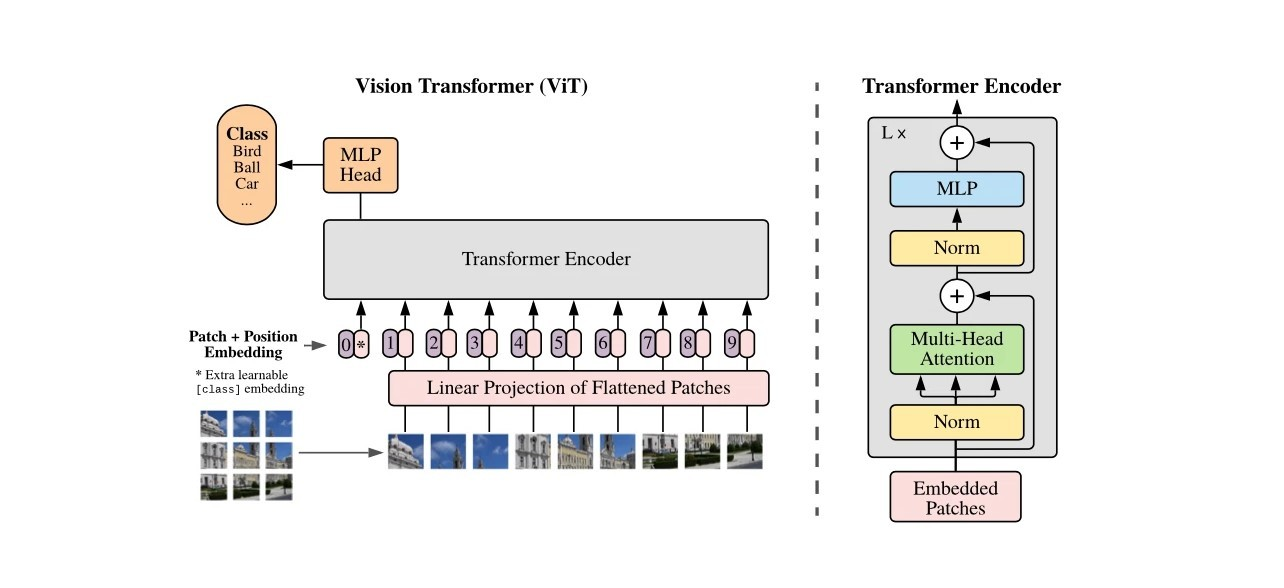


### Libraries

* **torch**: model implementation/low level configuration
* **einops**: "einstein operations" useful for tensor manipulation

Some libraries needed for readability...

In [30]:
pip install einops torchinfo torchmetrics

In [31]:
import torch
import torch.nn as nn
from torchinfo import summary               # shows a summary table of the model
from einops import rearrange, repeat        # functions for tensor dimension reordering and repeating
from einops.layers.torch import Rearrange   # same as rearrange but works as a torch layer

### Preprocessing: Tokenization of the image


First, is important to prepare the input of the ViT. In the case of ViTs the input sequence ideally would be all the pixels in the image, being each pixel a token per se. But this is very computationally costly (the Attention layer has a complexity of $\mathcal{O}(n² \times d)$, being '$n$' the sequence length). This means that an image of $224 \times 224$  will have a sequence length of 50176 tokens, and a single transformer layer will try to find each others correlations. Thats why patchification is needed.

Each patch of the image is flattened to create a token out of it (a patch would have height, width, and a number of channels. All the pixels in these 3 dimensions are flattened into one) and then linearly projected to get the embeddings.

Steps to create the transformer input from images:
1. Make patches out of the image
2. Flatten and make embeddings out of each patch (linear projection)
3. Add patch position information (positional embeddings + patch embeddings)
4. Concatenate an extra class embedding (learnable embedding. Will be explained later on)

Symbol legend:
- c = number of image channels
- H, W = pixel height and width of image
- n = total number of patches
- ph, pw = pixel height and width of patch
- D = embedding dimensionality

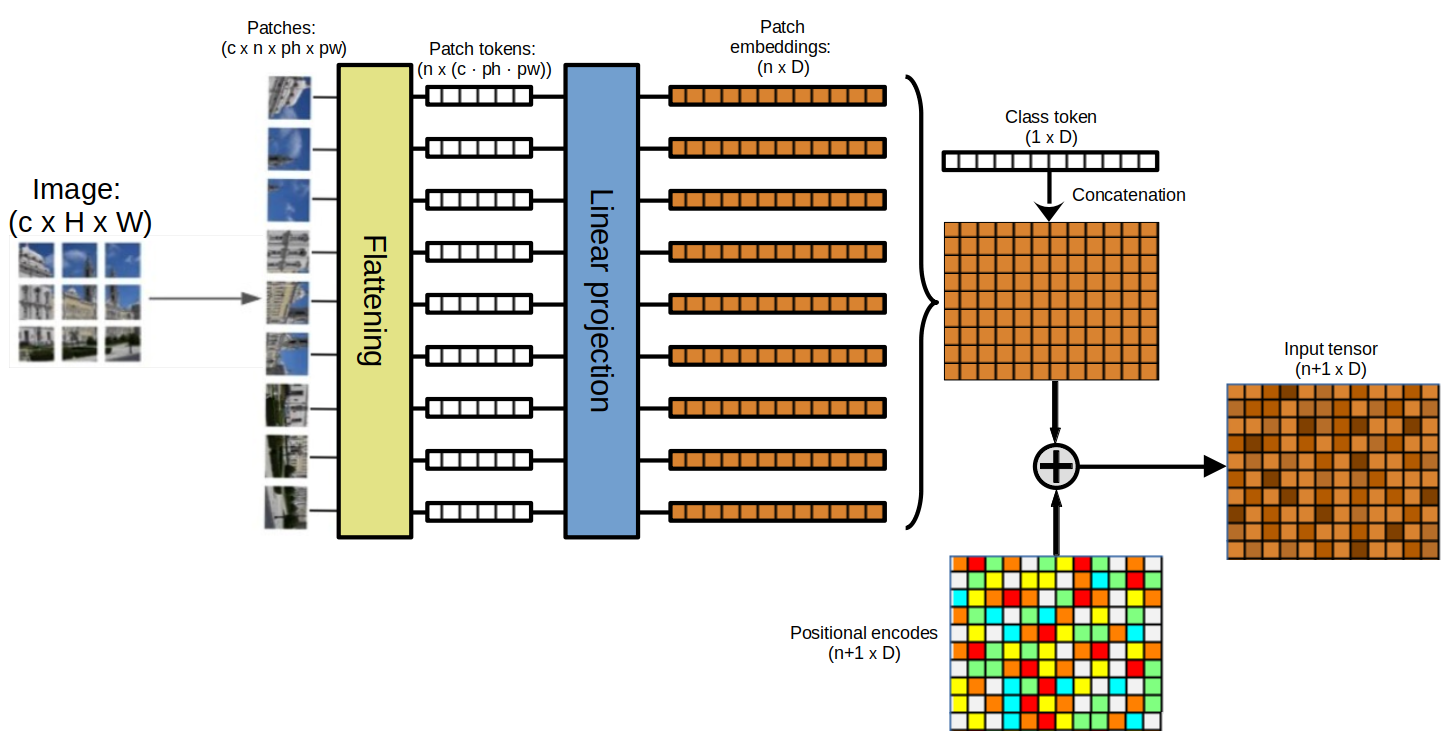

After we created the tokens out of the patches, and then linearly projected them to the inner dimensionality $D$, we append a Class token (CLS) adding a +1 to the number of tokens, and we sum to all the embeddings the positional information.

*Note: in the figures you will see that the embeddings are of size $n \times D$, and later, of $n+1 \times D$. This '+1' is just the extra CLS embedding added. To keep it simple we will call later on $n+1=N$ but this $N$ is not the same as the patch dimension*

In [32]:
class InputLayer(nn.Module):
  def __init__(self, image_size, patch_size, dim, channels=3, dropout=0.):
    """
    Input layer of the transformer. This will transform the input image into
    patch embeddings.

    Args:
      image_size - (int) number of pixels in each dimension of the input image
      patch_size - (int) number of pixels in each dimension of the patches
      dim - (int) inner dimensionality of the embeddings
      channels - (int) number of input channels
      dropout - (float) dropout rate
    """
    super(InputLayer, self).__init__()

    H, W = image_size, image_size       # usually the input images are squares, but its not obligatory
    ph, pw = patch_size, patch_size
    assert H % ph == 0 and W % pw == 0  # image dimensions must be divisible by the patch size

    num_patches = (H // ph) * (W // pw) # known in the figure as 'n'
    patch_dim = channels * ph * pw

    self.to_patch_embedding = nn.Sequential(
        Rearrange('b c (h ph) (w pw) -> b (h w) (ph pw c)', ph=ph, pw=pw), # 'h'/'w' number of horizontal and vertical patches. 'b' batch size
        nn.Linear(patch_dim, dim)
        )
    self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
    self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    x = self.to_patch_embedding(x)
    b, n, _ = x.shape

    cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b) # Creates as many CLS tokens as samples in the batch there are
    x = torch.cat((cls_tokens, x), dim=1)
    x += self.pos_embedding[:, :(n + 1)]
    x = self.dropout(x)

    return x

### Transformer module: implementation of MHSA and FFNN


Representation of a Transformer layer/module. These are concatenated one after the other, and the total number is defined by the "depth" hyperparameter.

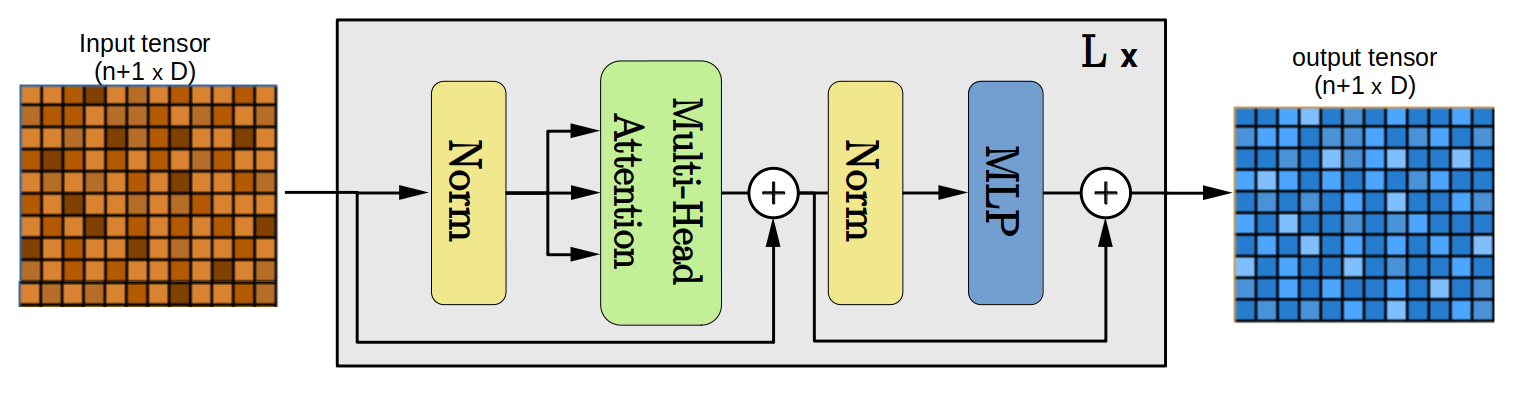

#### #1 - Multi-Head Self Attention

Attention, as its conceived in Transformers, "describes a weighted average of (sequence) elements with the weights dynamically computed based on an input query and element's keys".

In self-attention, each token of the sequence counts with its own query, key and value. The attention is achieved by checking the similarity of a query with all the sequence's keys and returned with an averaged value vector for each element.

\begin{align}
\\
\alpha_i = \frac{\exp\left(f_{attn}\left(\text{key}_i, \text{query}\right)\right)}{\sum_j \exp\left(f_{attn}\left(\text{key}_j, \text{query}\right)\right)}, \hspace{5mm} \text{out} = \sum_i \alpha_i \cdot \text{value}_i
\end{align}

Basically we want to decide which tokens we want to attend more, based on the weights, which are calculated with a score function (softmax). We apply the dot product attention in between the Q, K and V in order to attend to all elements in between each other, which are the shape $Q\in\mathbb{R}^{T\times d_k}$,  $K\in\mathbb{R}^{T\times d_k}$ and $V\in\mathbb{R}^{T\times d_v}$ where T is the sequence length and $d_k$ and $d_v$ are the hidden dimensionality of query/keys and values.

\begin{align}
\text{Attention}(Q,K,V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
\end{align}

The matrix multiplication $QK^T$ performs the dot product for every possible pair of queries and keys, resulting in a matrix of the shape $T\times T$. Each row represents the attention logits for a specific element
 to all other elements in the sequence. On these, we apply a softmax and multiply with the value vector to obtain a weighted mean (the weights being determined by the attention).

 **Why divide it by $\sqrt{d_k}$?** - As said in footnote 4 of original transformer paper: "To illustrate why the dot products get large, assume that the components of q and k are independent random variables with mean 0 and variance 1. Then their dot product, $q · k = \sum_{i=1}^{d_k}q_ik_i$, has mean 0 and variance dk".

 This scaling maintains an appropiate variance of attention values after initialization. We want this variance to be equal through the model, but it is affected when doing the dot product attention of Q and K since multiplying two vectors of variance $\sigma²$ results in a scalar that is $\times d_k$ higher variance:

 \begin{align}
 q_i \sim \mathcal{N}(0,\sigma^2), k_i \sim \mathcal{N}(0,\sigma^2) \to \text{Var}\left(\sum_{i=1}^{d_k} q_i\cdot k_i\right) = \sigma^4\cdot d_k
 \end{align}

 This will result in saturation towards 1 when doing the softmax over some of the logits and 0 for all others, giving more importance to some parameters rather than others and making the feature learning more difficult. Applying this scale mitigates this issue.



**Ok but, how is this implemented??**
Before we transformed the image $(c,H,W)$ into patches $(n, c, ph, pw)$, into 2D tokens $(n, (c · ph ·pw))$ and proyected them into 2D embeddings $(n, D)$. We also added an extra learnable embedding (cls token), so now the tensor has a shape of $(N, D)$, being N the sequence length and D the inner dimensionality.

We will create the Query, Key, and Value of the embeddings. After applying layer normalization, the embeddings are linearly proyected. This linear proyection applies the $W_Q, W_K, W_V$ matrices.

"*...this is a logical split only... A single data matrix is used for the Query, Key, and Value, respectively, with logically separate sections of the matrix for each Attention head. Similarly, there are not separate Linear layers, one for each Attention head. All the Attention heads share the same Linear layer but simply operate on their ‘own’ logical section of the data matrix*. - [Transformers Explained Visually (Part 3)](https://towardsdatascience.com/transformers-explained-visually-part-3-multi-head-attention-deep-dive-1c1ff1024853)"



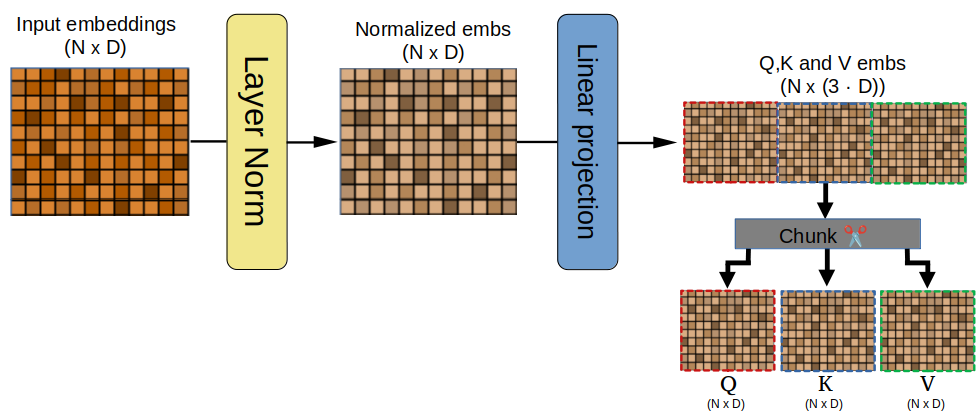

Once we have our Query, Key and Values, we can implement the Multi-Head Self-Attention mechanism. The QKV tensors are rearranged to have an extra dimension which would be the "heads" dimension. This will basically create attention maps for each head based on operating on the subtensors in this dimension. This achieves computational parallelization.

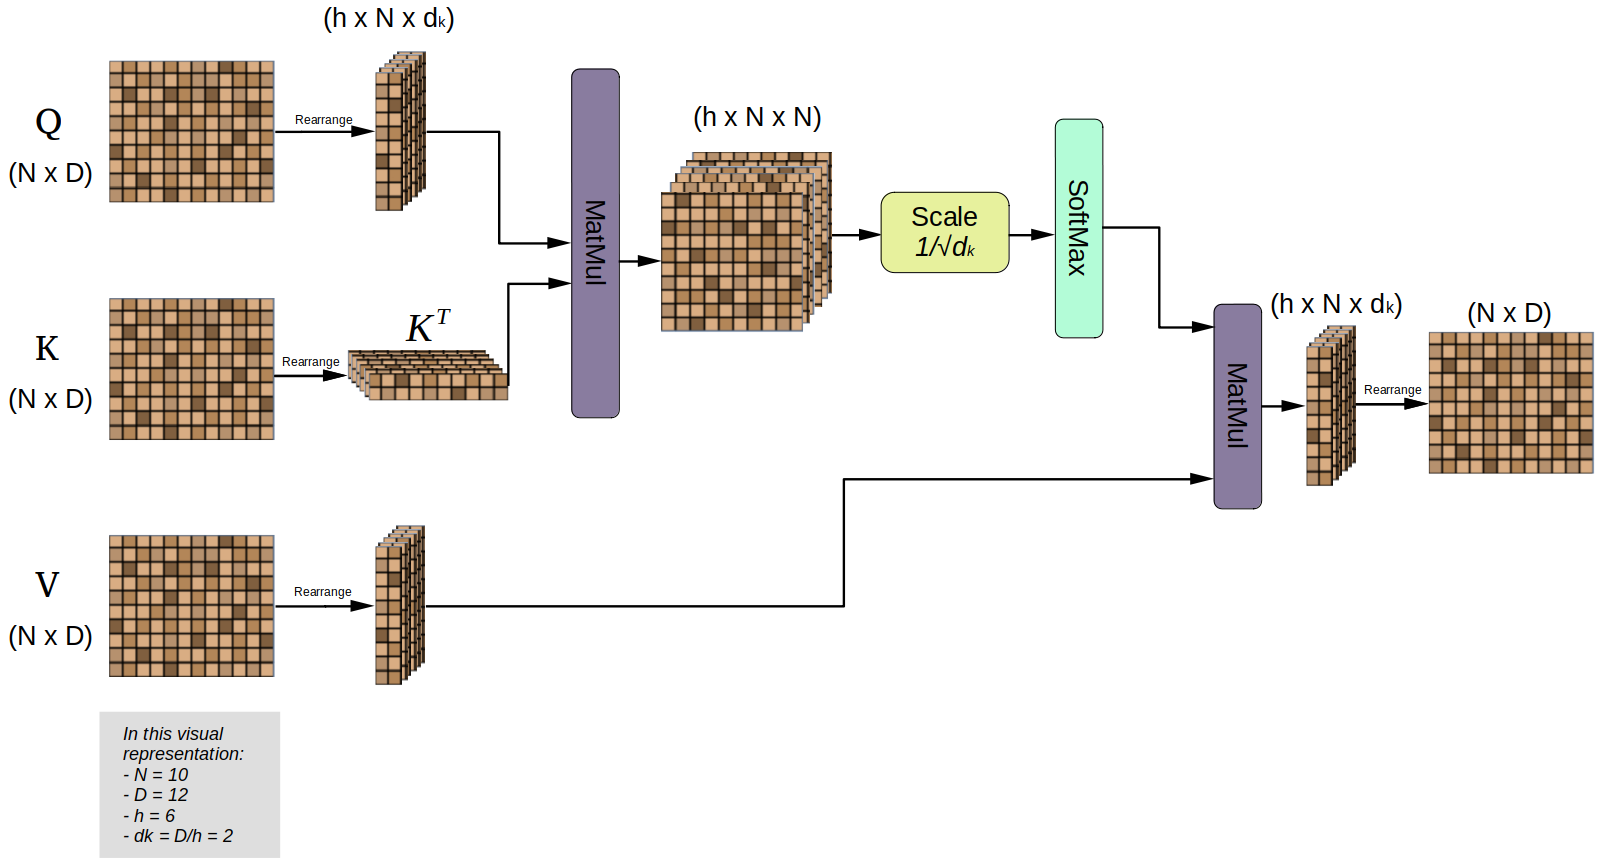

In [33]:
class Attention_Block(nn.Module):
  def __init__(self, dim, heads=8, dropout=0.):
    super(Attention_Block, self).__init__()

    dk = dim // heads # inner head dimension. Dim and number of heads must be multiple numbers

    self.heads = heads
    self.scale = dk ** -0.5 # scale = 1 / sqrt(dk)

    self.norm = nn.LayerNorm(dim)
    self.to_qkv = nn.Linear(dim, dim * 3, bias=False) # QKV projection
    self.attend = nn.Softmax(dim=-1)
    self.dropout = nn.Dropout(dropout)

    # self.to_out = nn.Sequential(
    #     nn.Linear(dk, dim),
    #     nn.Dropout(dropout)
    # ) if dim != dk else nn.Identity()

    self.to_out = nn.Identity()

  def forward(self, x):
    x = self.norm(x)
    qkv = self.to_qkv(x) # QKV projection
    qkv = qkv.chunk(3, dim=-1) # split into Q, K, V

    q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)
    dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

    attn = self.attend(dots)
    attn = self.dropout(attn)

    out = torch.matmul(attn, v)
    out = rearrange(out, 'b h n d -> b n (h d)')
    return self.to_out(out)

#### #2 - Feed Forward network (MLP)

This is the second half of the transformer module. Its a fully connected feed-forward network that operates separately with each representation. You can think of this as allowing the model to “post-process” the new information added by the previous Multi-Head Attention, and prepare it for the next attention block.

As it operates with each representation, input and output layers are of size D. Hidden layer is usualy of size $2/4/8\times D$, defined by hyperparameter "MLP factor". In the original ViT paper the width of the MLP is 4 times the size of D (MLP factor = 4).

The MLP contains two layers with **GELU** ¹ non linear activation function.

________________________________________________________
¹ Original transformer uses ReLU instead of GELU, but the sharpness of RELU can be suboptimal for big networks, making many neurons just turn 0 (GELU is smoother around 0 and is differentiable in all ranges) source: [Gaussian Error Linear Units](https://arxiv.org/pdf/1606.08415#page=6)

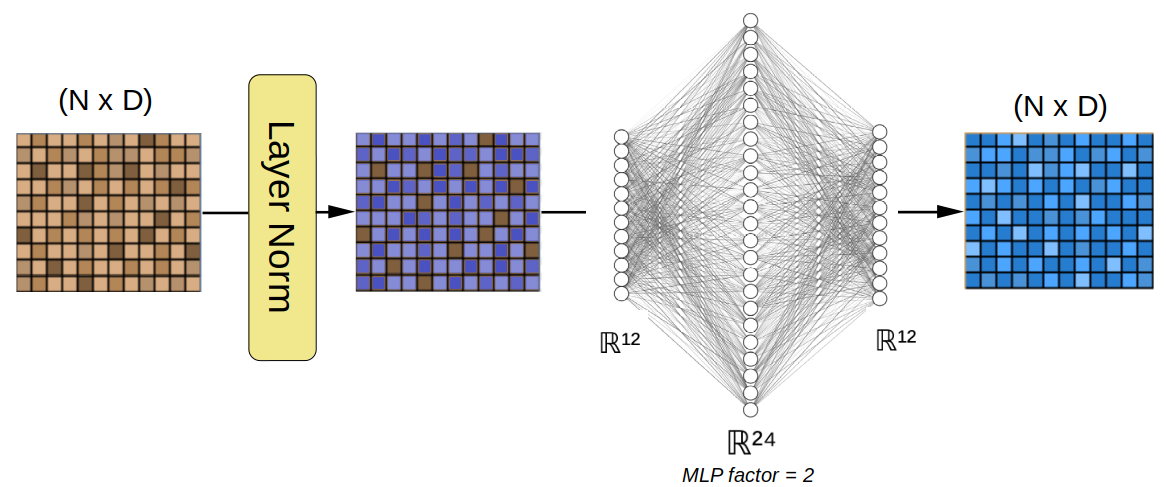

In [34]:
class FeedForward_Block(nn.Module):
  def __init__(self, dim, mlp_factor=4, dropout=0.):
        super(FeedForward_Block, self).__init__()

        hidden_dim = int(dim * mlp_factor)
        self.norm = nn.LayerNorm(dim)
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

  def forward(self, x):
    x = self.norm(x)
    x = self.net(x)
    return x

### Integration


Now that we have the multi-head self attention block, and the feed-forward block, its only left that we integrate both these two into the transformer module, together with the correspondant skip connections.

In [35]:
class Transformer(nn.Module):
  def __init__(self, dim, depth, heads, mlp_factor=4, dropout=0.):
    super(Transformer, self).__init__()
    self.layers = nn.ModuleList([])
    for _ in range(depth): # We stack the transformer layers
      self.layers.append(nn.ModuleList([
          Attention_Block(dim, heads=heads, dropout=dropout),
          FeedForward_Block(dim, mlp_factor=mlp_factor, dropout=dropout)
      ]))

  def forward(self, x):
    for attn, ff in self.layers:
      x = attn(x) + x # skip connection 1
      x = ff(x) + x   # skip connection 2
      return x

And now that we have the transformer module, we can finish off the Vision Transformer implementation. We integrate the input layer (patchifying/tokenization and embeddings of the image), we add the transformer layers (stacked one after the other "depth" times), and we finish off with the MLP head, which is just a fully connected network that will be the one that classifies.

##### Wait, what was the deal with the Class embedding again?
If you remember, at the very beginning we added a learnable class embedding. Instead of summing it somehow to the patch embeddings (like we did with the positional embeddings), this one is concatenated, and passed through the whole network as another embedding of the image.

This embedding is an idea that comes from BERT¹, where they added the 'CLS' token. This token can be interpreted as a "blank slate" that will embed a general representation of the whole sentence in a single embedding. This CLS token is the one used in the classification head as this would be capable of understanding the sequence as a whole. The ViT employs the same logic.

Curiously enough, this learnable embedding can be used for other tasks. As it is easily implemented, depending on your application you could add other learnable embeddings that could be used for other tasks (masking, question-answering, regression...). This is one of the 'pros' of input tokenization.
___
¹[*BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding*](https://arxiv.org/abs/1810.04805)

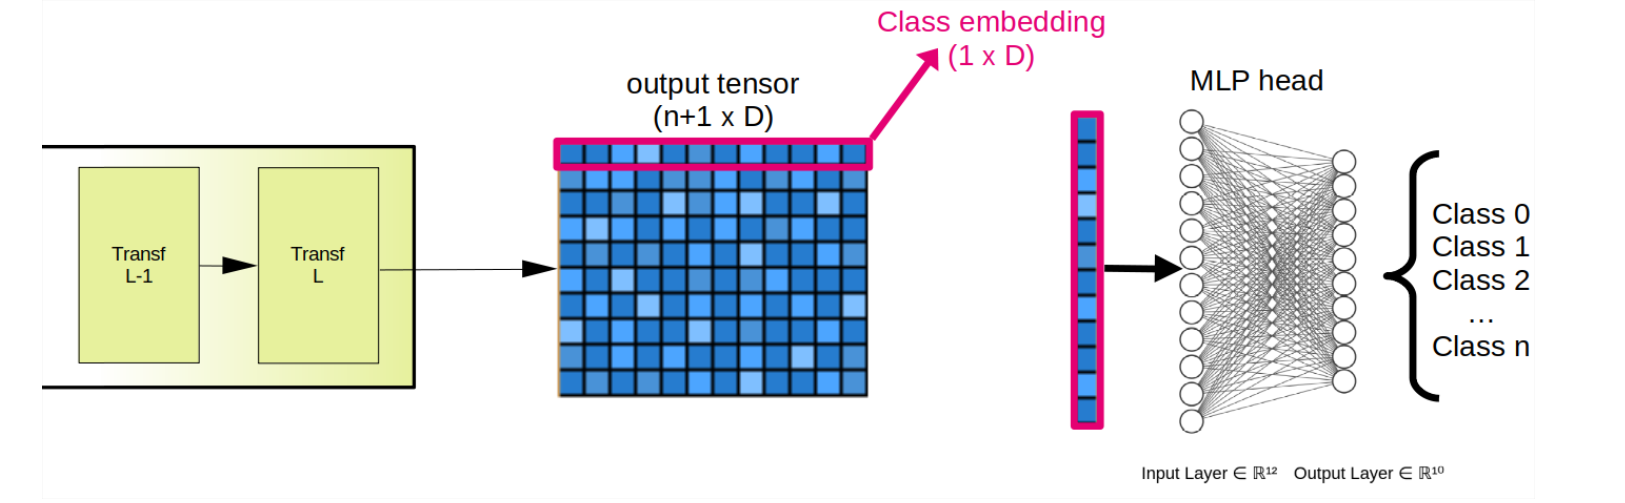

The extra learnable embedding has proven in some cases to be very effective, and helps with knowledge distillation¹. But in some cases a Global Average Pooling of the token embeddings has proven to be more effective². We will implement one method or other depending on the hyperparameter "pool".

___
¹[Training data-efficient image transformers & distillation through attention](https://arxiv.org/abs/2012.12877)
²[TransCrowd: weakly-supervised crowd counting with transformers](https://arxiv.org/abs/2104.09116)

In [36]:
class ViT(nn.Module):
  def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_factor=4, dropout=0., channels=3, pool='cls'):
    super(ViT, self).__init__()

    self.image_size = image_size
    self.channels = channels
    self.patch_size = patch_size
    self.num_classes = num_classes
    self.dim = dim
    self.depth = depth
    self.heads = heads
    self.mlp_factor = mlp_factor
    self.dropout = dropout

    self.input_layer = InputLayer(image_size, patch_size, dim, channels, dropout)

    self.transformer = Transformer(dim, depth, heads, mlp_factor, dropout)

    self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    self.pool = pool

  def forward(self, x):
    x = self.input_layer(x)

    x = self.transformer(x)

    x = x.mean(dim=1) if self.pool == 'gap' else x[:, 0] # Here we choose, CLS token or GAP

    return self.mlp_head(x)


### Model definition

We define our model as a function for easy implementation. This eases the model loading and also allows to define multiple versions of it.

In [37]:
# General model definition. Hyperparameter configurable:

def VisionTransformer(args):
  model = ViT(image_size=args['img_size'],
              patch_size=args['patch_size'],
              num_classes=10,   # We will use CIFAR10 dataset
              dim=args['vit_dim'],
              depth=args['vit_depth'],
              heads=args['n_heads'],
              mlp_factor=args['mlp_factor'],
              dropout=args['dropout'])
  return model

# Pre-defined ViT models
# Mnemotecnic: vit_dim_depth_heads()

# ViT Tiny:
def vit_192_12_3(args):
  model = ViT(image_size=args['img_size'],
              patch_size=args['patch_size'],
              num_classes=10,
              dim=192,
              depth=12,
              heads=3,
              mlp_factor=4,
              dropout=0.1)
  return model

# ViT Base:
def vit_768_12_12(args):
  model = ViT(image_size=args['img_size'],
              patch_size=args['patch_size'],
              num_classes=10,
              dim=768,
              depth=12,
              heads=12,
              mlp_factor=4,
              dropout=0.1)
  return model

# ViT Large:
def vit_1024_24_16(args):
  model = ViT(image_size=args['img_size'],
              patch_size=args['patch_size'],
              num_classes=10,
              dim=1024,
              depth=24,
              heads=16,
              mlp_factor=4,
              dropout=0.1)
  return model

###### Forward pass test:

In [38]:
# Create a randomized input-like tensor (resembling an image):
x = torch.randn(1,3,224,224)

# Create a Vision Transformer
model = ViT(image_size=224,
              patch_size=16,
              num_classes=10,
              dim=1024,
              depth=12,
              heads=8,
              mlp_factor=4)

# Forward pass
y = model(x)
print(y)
print(y.shape)

tensor([[ 0.2742, -0.7140,  0.2925, -0.5717, -0.1973, -0.5017,  0.2253,  0.3003,
          0.8051, -0.3924]], grad_fn=<AddmmBackward0>)
torch.Size([1, 10])


In [39]:
# Summarization of the ViT created
summary(model, input_size=x.shape,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"],
        depth=10)

Layer (type (var_name))                       Input Shape               Output Shape              Param #                   Trainable
ViT (ViT)                                     [1, 3, 224, 224]          [1, 10]                   --                        True
├─InputLayer (input_layer)                    [1, 3, 224, 224]          [1, 197, 1024]            202,752                   True
│    └─Sequential (to_patch_embedding)        [1, 3, 224, 224]          [1, 196, 1024]            --                        True
│    │    └─Rearrange (0)                     [1, 3, 224, 224]          [1, 196, 768]             --                        --
│    │    └─Linear (1)                        [1, 196, 768]             [1, 196, 1024]            787,456                   True
│    └─Dropout (dropout)                      [1, 197, 1024]            [1, 197, 1024]            --                        --
├─Transformer (transformer)                   [1, 197, 1024]            [1, 197, 1024]          

### Training the model

#### Dataset and dataloaders

We will create the training, validation and test dataloaders for the model. This part is kinda trivial/out of the scope of the tutorial, but nevertheless I'll explain what I consider necessary.

 The dataset chosen is the CIFAR10 dataset which is a popular benchmark dataset that consist of 60k, 32x32 pixels, 10 classes images (6k images per class). The library 'torchvision' has the dataset, among others, available for direct local download. It also allows us to do some computer vision pre-processing like data augmentation, normalization...

 First we will define the transformations of the dataset. We will apply normalization to them and for the train images we will apply random horizontal flips and crops to augment the data.

In [40]:
from torch.utils import data
import matplotlib.pyplot as plt
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

DATASET_PATH = "data"
torch.manual_seed(42) # here we define the random seed for better replicability

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                     ])
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                     ])

We create now the train, val and test datasets. The train and val datasets comes from the same pool of images but the val dataset shouldn't be subjected to data augmentation (thats why we set for both of them "train=True" but the creation of the sets is separated).

In [41]:
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)

train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


And now we create the dataloaders. Dataloaders are samplers that wrap an iterable around the datasets to enable easy access to the samples. Here

In [42]:
# We define a set of data loaders that we can use for various purposes later.
batch_size = 128

train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=2)
val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2)
test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2)

And now we visualize some images using the matplotlib library. If we have set the random seed correctly (seed=42), the images that would appear would be a weird cat, a horse, a close up cat and an orange cat. 🐱

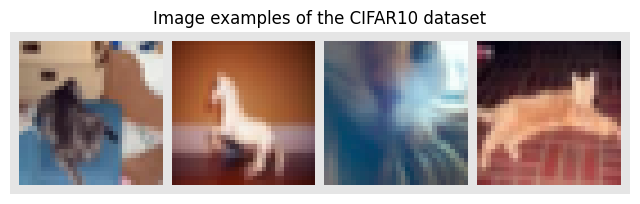

In [43]:
# Visualize some examples
NUM_IMAGES = 4
CIFAR_images = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

#### Defining the trainer

Personally, I like to define my own scripts for training, testing and evaluate. Here is an evaluation function that will use the validation dataset and the model to calculate the loss and accuracy over the validation dataset. This can also be used for the testing dataset.

In [44]:
from torchmetrics import Accuracy
from tqdm import tqdm

def evaluation(model, val_loader, loss_fn):
    """
    Evaluates a classification model measuring its accuracy and average loss
    using the provided loss function.

    :param model: The model to evaluate
    :param val_loader: DataLoader for the validation dataset
    :param loss_fn: Loss function to use for evaluation
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    num_classes = model.num_classes

    # Initialize metrics
    accuracy = Accuracy(task='multiclass', num_classes=num_classes).to(device)
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, colour='red'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, dim=1)

            # Update metrics
            accuracy.update(preds, labels)

    # Compute final metric results
    final_accuracy = accuracy.compute()

    # Average loss over all validation data
    average_loss = total_loss / len(val_loader.dataset)

    return {
        'accuracy': final_accuracy.item(),
        'average_loss': average_loss
    }

And here we define is the Trainer, which is an object that will create the configuration necessary to train a model.

This Trainer:


1. Pre-evaluates the model to have a baseline performance of the model
2. Optimizes using AdamW (modified Adam that decouples weight decay from the gradient update)
3. Uses Cross Entropy as the loss function (common for multi-class classification)
4. Uses a learning rate scheduler
5. Will halt the training after a pre-defined number of epochs (patience)


In [45]:
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F

class Trainer:
    def __init__(self, model, train_loader, val_loader, args, patience=20):
        """
        Creates an object used for training a model and save the weight checkpoints.
        :param model: The model to train

        :param train_loader: DataLoader for the training dataset
        :param val_loader: DataLoader for the validation dataset
        :param args: Dictionary of hyperparameters
        :param patience: Number of epochs to wait before early stopping
        """
        self.args = args
        self.epochs = args['epochs']
        self.lr = args['lr']
        self.model = model

        self.loss_fn = F.cross_entropy
        self.optimizer = optim.AdamW(model.parameters(), lr=args['lr'])
        self.train_loader, self.val_loader = train_loader, val_loader
        self.lr_scheduler = optim.lr_scheduler.MultiStepLR(self.optimizer, milestones=[100, 200, 300, 400], gamma=0.1)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.best_loss = np.inf
        self.patience = patience
        self.tries = 0

    def step(self, x, y):
        """
        Performs a single training step
        """
        self.optimizer.zero_grad(set_to_none=True)
        preds = self.model(x)
        loss = self.loss_fn(preds, y)
        loss.backward()
        self.optimizer.step()
        return loss

    def pre_evaluation(self):
        """
        Gets a baseline performance of the model
        """
        print('\nModel pre-evaluation...')
        results = evaluation(self.model, self.val_loader, self.loss_fn)
        return results['average_loss']


    def print_summary(self):
        print(f'\nTraining hyperparameters'
              f'\nDevice: {self.device}'
              f'\nLearning rate: {self.lr}'
              f'\nDropout: {self.args["dropout"]}'
              f'\nEpochs: {self.epochs}'
              f'\nPatience: {self.patience}'
              f'\nBatch size: {self.args["batch_size"]}'
              f'\n')

    def save_model(self, val_loss):
        """
        Saves a checkpoint of the model if the validation loss is lower than the previous best
        """
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            torch.save(self.model.state_dict(), 'best_model.pth')

    def run(self):
        """
        Runs the training loop
        """
        self.print_summary()

        self.model.to(self.device)

        self.best_loss = self.pre_evaluation()
        print(f'Pre-evaluation loss: {self.best_loss}')


        running_loss = 0.0

        for epoch in range(self.epochs):
            self.model.train()
            print(f'\nCurrent Learning Rate: {self.optimizer.param_groups[0]["lr"]}')
            for i, (x, y) in tqdm(enumerate(self.train_loader), total=len(self.train_loader)):
                x, y = x.to(self.device), y.to(self.device)
                loss = self.step(x, y)
                running_loss += loss.detach().item()

            val_results = evaluation(self.model, self.val_loader, self.loss_fn)
            train_loss = running_loss / len(self.train_loader)
            running_loss = 0.0
            print(
                f'Epoch {epoch + 1}'
                f'\nAccuracy: {val_results["accuracy"]}'
                f'\n\nTraining loss: {train_loss}'
                f'\nValidation loss: {val_results["average_loss"]}\n')

            self.lr_scheduler.step(val_results["average_loss"])

            self.save_model(val_results["average_loss"])

            if self.tries > self.patience:
                break


#### Here is where the fun begins

In the model definition and trainer definition, many of the hyperparameters come from a dictionary variable called "args". Here is where we define this dictionary, and complete with both training and architecture parameters.

*Note: this ideally comes from a parser where executing the script from cmd will allow you to modify the parameters directly before executing the program*.
*Warning: Batch_size is actually defined where the dataloaders are created!*

In [46]:
# Hyperparameter definition
args = {'batch_size': 128,
        'lr': 3e-3,
        'epochs': 5,
        'img_size': 32,
        'patch_size': 4,
        'vit_dim': 256,
        'vit_depth': 6,
        'n_heads': 8,
        'mlp_factor': 4,
        'dropout': 0.2
        }

We create now our ViT. Since we defined the hyperparameters dictionary we can use de model VisionTransformers(), but we could also use  the pre-defined models we made before.

In [47]:
model = VisionTransformer(args)
summary(model, input_size=(1, 3, 32, 32),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"],
        depth=10)


Layer (type (var_name))                       Input Shape               Output Shape              Param #                   Trainable
ViT (ViT)                                     [1, 3, 32, 32]            [1, 10]                   --                        True
├─InputLayer (input_layer)                    [1, 3, 32, 32]            [1, 65, 256]              16,896                    True
│    └─Sequential (to_patch_embedding)        [1, 3, 32, 32]            [1, 64, 256]              --                        True
│    │    └─Rearrange (0)                     [1, 3, 32, 32]            [1, 64, 48]               --                        --
│    │    └─Linear (1)                        [1, 64, 48]               [1, 64, 256]              12,544                    True
│    └─Dropout (dropout)                      [1, 65, 256]              [1, 65, 256]              --                        --
├─Transformer (transformer)                   [1, 65, 256]              [1, 65, 256]            

In [ ]:
trainer = Trainer(model, train_loader, val_loader, args)
trainer.run()

### Testing the model

#### Defining the tester
The same as the trainer, we also create an object that is the Tester. This allow us to have a framework were we can evaluate multiple architectures in the same conditions in a tidy way. This object will use the test set on the trained model, and will store in a csv a log of the results.

In [65]:
import pandas as pd
import torch.nn.functional as F
import os
from tabulate import tabulate


class Tester:
    def __init__(self, model, test_loader, args):
        self.model = model
        self.test_loader = test_loader
        self.args = args
        self.loss_fn = F.cross_entropy
        self.results_dir = 'results/'
        self.results_file = f"ViT_performance_results.csv"

        if not os.path.exists(self.results_dir):
            os.makedirs(self.results_dir)

    def run(self):
        results = evaluation(self.model, self.test_loader, self.loss_fn)
        test_df = pd.DataFrame({'test_loss': results["average_loss"],
                                'accuracy': results["accuracy"]}, index=[0])
        print(tabulate(test_df, headers='keys', tablefmt='psql', showindex=False))
        test_df.to_csv(os.path.join(self.results_dir, self.results_file), index=False)
        print(f'Test results file: {self.results_file}')


#### Testing the model

In [ ]:
tester = Tester(model, test_loader, args)
tester.run()

100%|██████████| 79/79 [00:02<00:00, 28.75it/s]

+-------------+------------+
|   test_loss |   accuracy |
|-------------+------------|
|     1.49749 |     0.4628 |
+-------------+------------+
Test results file: ViT_performance_results.csv


### Loading a pre-trained model

When pre-loading weights into a PyTorch architecture, you typically start by loading a pre-trained model or a model saved from a previous training session. This involves using the *load_state_dict()* method on the model object, passing in the state dictionary that contains the weights. Here are the main considerations and precautions:
1. Compatibility: The model you are trying to load the weights to, and the same weights, should have the exact same configuration and structure (this means: shape of architecture, device where it was trained...). Not considering this will not load correctly the model.
2. Dataset preprocessing: If you are going to fine-tune a pre-trained model, its important how the data was pre-processed on the original training. Try to use the same normalization parameters.
3. If you are going to re-train a pre-trained model, try to begin with a low learning rate as a big learning rate can mess with the pre-trained weights configured.



In [62]:
def loadModel(model_name, args, ckpt_file='best_model.pth'):
    """
    Loads pre-trained weights to a model.
    :param model_name: Name of the model (as they are defined)
    :param args: Dictionary of hyperparameters
    :param ckpt_file: Path to the checkpoint file
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = eval(model_name + f'({args})')
    print(f'Loading pre-trained model of {model_name}. Checkpoint: {ckpt_file}')

    try:
        checkpoint = torch.load(ckpt_file, map_location=torch.device(device))
        model.load_state_dict(checkpoint, strict=False)
        model.to(device)
        print(f"Model {model_name} loaded")
    except FileNotFoundError:
        print(f'Checkpoint file {ckpt_file} not found. The model will be loaded from scratch!')
    except RuntimeError as e:
        print(f'Error loading checkpoint: {e}. Check that the model architecture matches the checkpoint')
    except Exception as e:
        print(f'An unexpected error occurred: {e}. Model will be loaded from scratch!')

    print(f'\nSize of the architecture: {sum(p.numel() for p in model.parameters())} parameters')
    model.to(device)
    print("The model will be running on", device, "device")

    return model

In [63]:
model = loadModel('VisionTransformer', args)

Loading pre-trained model of VisionTransformer. Checkpoint: best_model.pth
Model VisionTransformer loaded

Size of the architecture: 4371722 parameters
The model will be running on cpu device


In [67]:
tester = Tester(model, test_loader, args)
tester.run()

100%|██████████| 40/40 [00:13<00:00,  3.06it/s]


+-------------+------------+
|   test_loss |   accuracy |
|-------------+------------|
|    0.270729 |     0.9494 |
+-------------+------------+
Test results file: ViT_performance_results.csv
